**Вопрос 1.** Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import itertools
import warnings

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col = [0], parse_dates=[0])

In [3]:
data_m = data.resample('M').mean()

In [4]:
data_m.head(10)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000
2002-04-30,28534.731572,2002.0,4.0,15.511822,2.0,105.511822,15.668985,2.828929,11.511822,0.000000,0.000000,0.000000
2002-05-31,28073.653226,2002.0,5.0,16.000000,2.0,136.000000,20.000000,3.000000,11.500000,0.032258,0.032258,0.032258
2002-06-30,33585.919444,2002.0,6.0,15.500000,2.0,166.500000,24.333333,3.166667,11.500000,0.000000,0.000000,0.000000
2002-07-31,38041.896505,2002.0,7.0,16.000000,3.0,197.000000,28.741935,2.806452,11.500000,0.032258,0.032258,0.032258
2002-08-31,38014.021505,2002.0,8.0,16.000000,3.0,228.000000,33.129032,3.096774,11.500000,0.000000,0.000000,0.000000
2002-09-30,31281.468056,2002.0,9.0,15.500000,3.0,258.500000,37.500000,3.000000,11.500000,0.033333,0.033333,0.033333


**Вопрос 2.** Подберите параметры модели SARIMAX для этого ряда.



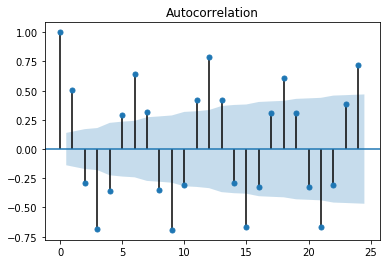

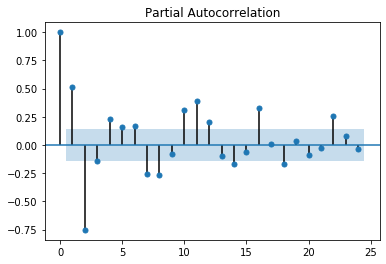

In [5]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=24)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=24)
plt.show()

График ACF демонстрирует некотрую сезонность с высокой корреляцией потребления энергии в зимний и летний период (лаг 12 и 6, соотвтественно).

Для параметра p имеет смысл использовать значение 2, так как график ACF имеет синусоидную форму, а первые два лага показывают высокую корреляцию: первый - положительную; второй - отрицательную

Воспользуемся сеточным поиском параметров

In [6]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку d и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [7]:
data_m['PJME_MW'].values.shape

(200,)

In [8]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения
N1 = 80   # берем дданные не от начала - так быстрее работает
N2 = 8  # число точек для теста
nforecast = N2+5

In [9]:
warnings.filterwarnings("ignore") # отключает предупреждения
result = pd.DataFrame()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[N1:-N2],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            result = result.append(
                {'param': param,
                 'param_seasonal': param_seasonal,
                 'aic': results.aic
                }, 
                ignore_index=True)
            
#             print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [10]:
result.nsmallest(10, 'aic')

,aic,param,param_seasonal
161,1263.216978,"(2, 2, 2)","(0, 1, 2, 12)"
35,1266.442858,"(0, 1, 2)","(0, 1, 2, 12)"
89,1268.096121,"(1, 1, 2)","(0, 1, 2, 12)"
53,1268.890116,"(0, 2, 2)","(0, 1, 2, 12)"
143,1278.952923,"(2, 1, 2)","(0, 1, 2, 12)"
107,1281.999634,"(1, 2, 2)","(0, 1, 2, 12)"
155,1282.182180,"(2, 2, 1)","(0, 1, 2, 12)"
71,1286.386509,"(1, 0, 2)","(0, 1, 2, 12)"
125,1288.386305,"(2, 0, 2)","(0, 1, 2, 12)"
83,1290.508268,"(1, 1, 1)","(0, 1, 2, 12)"


Построим модель на основе набора параметров с наименьшим aic

In [11]:
mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[N1:-N2],order=[2,2,2],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()

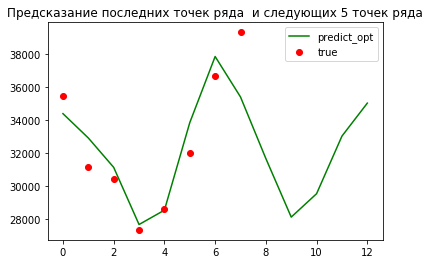

In [12]:
pred_dynamic_opt = results_opt.forecast(nforecast) #делаем предсказание на 5 точек от текущего конца ряда

plt.plot(pred_dynamic_opt, 'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()

plt.show()

In [13]:
results_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4267,0.246,-1.734,0.083,-0.909,0.056
ar.L2,-0.4653,0.111,-4.183,0.000,-0.683,-0.247
ma.L1,-0.8152,0.302,-2.703,0.007,-1.406,-0.224
ma.L2,-0.1825,0.262,-0.696,0.486,-0.697,0.332
ma.S.L12,-0.5067,0.137,-3.708,0.000,-0.775,-0.239
ma.S.L24,-0.1381,0.129,-1.069,0.285,-0.391,0.115
sigma2,2.244e+06,1.14e-07,1.97e+13,0.000,2.24e+06,2.24e+06


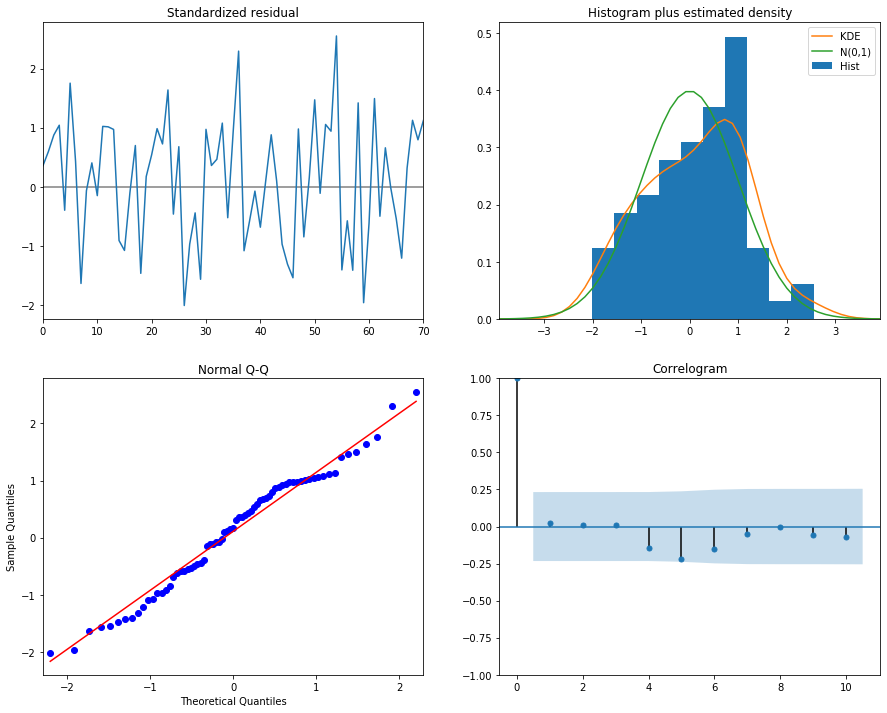

In [14]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()

**Вопрос 3.** Сделайте вывод о том, как изменилась модель по сравнению с недельной.


**Ответ**: Качество прогноза ухудшилось. Диагностика (plot_diagnostics) показала, что остатки модели не согласуются с нормальным законом распределения 


**Вопрос 4.** Возмите вариант 1 или 2 
    - Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    - Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19  (по любой стране кроме Китая на дневных графиках )



In [15]:
brent = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates = [0])
brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [16]:
brent = brent.asfreq('1D', method='PAD')
brent = brent.resample('W').mean()

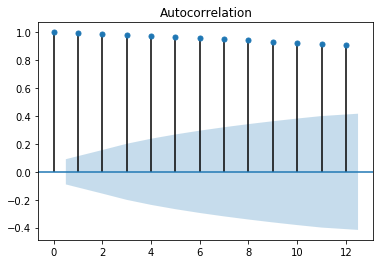

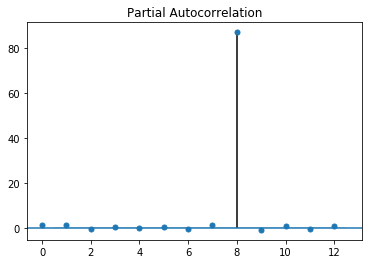

In [17]:
sm.graphics.tsa.plot_acf(brent['Значение'].values, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(brent['Значение'].values, lags=12)
plt.show()

Построим ACF и PACF для первых разностей

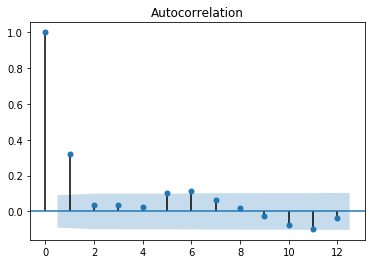

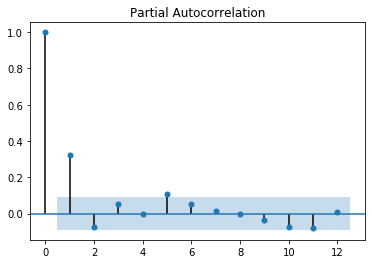

In [18]:
brent_dif = brent['Значение'].diff(1)

sm.graphics.tsa.plot_acf(brent_dif[1:], lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(brent_dif[1:], lags=12)
plt.show()

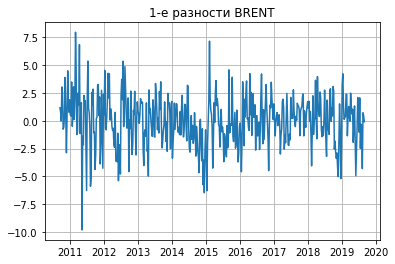

In [19]:
plt.plot(brent_dif)
plt.grid()
plt.title('1-е разности BRENT')
plt.show()

In [20]:
# Определим p, d и q в диапазоне 0-3
d = range(0,3)
p = range(0,3) 
q = range(0,3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

In [21]:
brent_dif.values.shape

(470,)

Сеточный поиск параметров

In [22]:
warnings.filterwarnings("ignore") # отключает предупреждения
brent_result = pd.DataFrame()

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_bd = sm.tsa.statespace.SARIMAX(brent_dif[100:-100],order=param,seasonal_order=[0,0,0,0],
                                          stepwise=False, approximation=False, max_order=2)

        results_ = mod_bd.fit()
        
        brent_result = brent_result.append(
                {'param': param,
                 'param_seasonal': param_seasonal,
                 'aic': results_.aic
                }, 
                ignore_index=True)
    except:
        continue

In [23]:
brent_result.nsmallest(10, 'aic')

,aic,param,param_seasonal
1,1124.724249,"(0, 0, 1)","[0, 0, 0, 0]"
9,1124.728209,"(1, 0, 0)","[0, 0, 0, 0]"
2,1125.546943,"(0, 0, 2)","[0, 0, 0, 0]"
10,1125.609418,"(1, 0, 1)","[0, 0, 0, 0]"
18,1125.620267,"(2, 0, 0)","[0, 0, 0, 0]"
5,1126.825397,"(0, 1, 2)","[0, 0, 0, 0]"
13,1127.392991,"(1, 1, 1)","[0, 0, 0, 0]"
11,1127.533821,"(1, 0, 2)","[0, 0, 0, 0]"
19,1127.592475,"(2, 0, 1)","[0, 0, 0, 0]"
22,1128.065106,"(2, 1, 1)","[0, 0, 0, 0]"


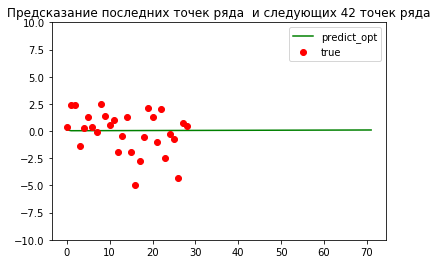

In [24]:
N1=100
N2=30
nforecast = N2+42
modb_optd = sm.tsa.statespace.SARIMAX(brent_dif[N1:-N2],
                               order=[0,0,1],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_optd = modb_optd.fit()
#делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = resultsb_optd.forecast(nforecast) 

plt.plot(pred_dynamic_opt.values,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(brent_dif.values[-N2:-1],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 42 точек ряда')
plt.ylim([-10,10])
plt.legend()
plt.plot()
plt.show()

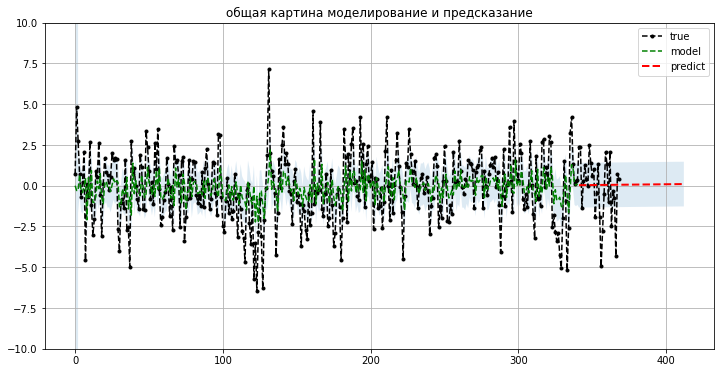

In [25]:
N3 = 0
predict_ = resultsb_optd.get_prediction(end=resultsb_optd.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(brent_dif.values[N3+N1:-1], '--k.',label='true')
plt.ylim([-10,10])
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], '--g',label='model') 
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci.iloc[N3:, 0], predict_ci.iloc[N3:, 1], alpha=0.15)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');


**Вопрос 5.** Оцените результат моделирования



Параметры [0,0,1] для ARIMA наиболее точно предсказывают модель случайного биения на выборке недельных значений цены Brent

**Вопрос 6.** Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

**Ответ:** Для применения техник регрессии на основе ARIMA требуется достаточно большая выборка данных и соблюдение допущений относительно стационарности ряда. При наличии сезонности имеет смысл использовать SARIMA